## Tasks

* Implement vanilla autoencoder
* Train it on MNIST dataset MNIST
* Display digits recovered dy AE
* Display distribution of embeddings in latent space

## Ideas for extra work

* Find the best latent space size
* Implement noise filtration with AE
* Test vector arithmetic in laent space
* Implemet VAE
    * Use Autoencoder class as base class
    * Implement VAE Loss class
    * Plot embeddings manifold in VAE latent space
    * Compare decoding results VAE latent space with vanilla Autoencoder results
* Replace reconstruction loss from MSE to BCE
* Implement Conditional Autoencoder or CVAE

## Imports

In [1]:
import os
import abc
import typing
import random
import warnings

import tqdm
import torch
import wandb
import numpy
import seaborn
import torchvision
import sklearn.manifold
import matplotlib.pyplot as plt
import torch.utils.data as torchdata
from torchvision.transforms import v2 as transforms

warnings.filterwarnings("ignore")

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


## Dataset

http://yann.lecun.com/exdb/mnist/

The MNIST database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples.

The images were centered in a 28x28 image by computing the center of mass of the pixels.

In [2]:
std = torch.tensor([ 0.3081 ])
mean = torch.tensor([ 0.1307 ])
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

train_ds = torchvision.datasets.MNIST('mnist', train = True, download = True, transform = transform)
test_ds = torchvision.datasets.MNIST('mnist', train = False, download = True, transform = transform)

Display some samples along with corresponding labels

In [3]:
# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = [ 0., 0., 0. ], std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = [ 1., 1., 1. ])
])

def display_image(image: torch.Tensor, label: str):
    plt.axis('off')
    plt.title('{}'.format(label))
    plt.imshow((denormalize(image).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(numpy.uint8))

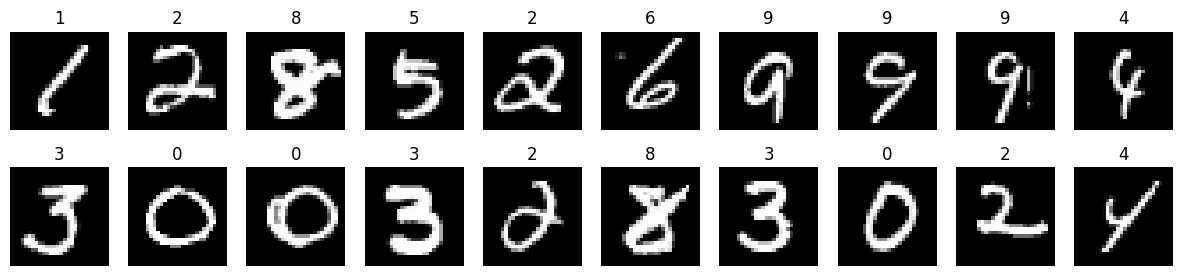

In [4]:
def display_examples(dataset: torch.utils.data.Dataset, row: int):
    train_loader = torchdata.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        display_image(image, label)

# Display some samples from each dataset
fix_random()
plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_ds, 1)
display_examples(test_ds, 2)

Define dataloaders

In [5]:
train_loader = torch.utils.data.DataLoader(train_ds, shuffle = True, batch_size = 128)
test_loader = torch.utils.data.DataLoader(test_ds, shuffle = False, batch_size = 256)

## Abstract

### Model

In [6]:
class BaseEncoder(torch.nn.Module, abc.ABC):
    def __init__(self, latent_size: int):
        super().__init__()
        self.latent_size = latent_size

    @abc.abstractmethod
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

class BaseDecoder(torch.nn.Module, abc.ABC):
    def __init__(self, latent_size: int):
        super().__init__()
        self.latent_size = latent_size

    @abc.abstractmethod
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError
    
class BaseAutoEncoder(torch.nn.Module, abc.ABC):
    def __init__(self, latent_size: int):
        super().__init__()
        self.latent_size = latent_size

    def forward(self, input: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        embedding = self.encoder(input)
        recovered_input = self.decoder(embedding)
        return recovered_input, embedding

In [7]:
def test_encoder(encoder: BaseEncoder):
    dummy = torch.randn((10, 1, 28, 28))
    assert encoder(dummy).shape == (10, encoder.latent_size)

def test_decoder(decoder: BaseDecoder):
    dummy = torch.randn((10, decoder.latent_size))
    assert decoder(dummy).shape == (10, 1, 28, 28)

def test_autoencoder(autoencoder: BaseAutoEncoder):
    test_encoder(autoencoder.encoder)
    test_decoder(autoencoder.decoder)
    dummy = torch.randn((10, 1, 28, 28))
    outputs, embeddings = autoencoder(dummy)
    assert outputs.shape == dummy.shape
    assert embeddings.shape == (10, autoencoder.latent_size)

### Train

In [8]:
def train(model: BaseAutoEncoder, name: str = 'AutoEncoder', learning_rate: float = 1e-3, n_epochs: int = 25) -> BaseAutoEncoder:
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
    wandb.init(project = "CV-HW-8", name = name, anonymous = "allow")
    wandb.watch(model, log = "all")
    for epoch in range(n_epochs):
        sum_loss = 0
        for (images, targets) in tqdm.tqdm(train_loader, desc = 'Epoch {}'.format(epoch + 1)):
            model.train() # Enter train mode
            optimizer.zero_grad() # Zero gradients
            output, _ = model(images.to(device)) # Get predictions
            loss = torch.nn.functional.mse_loss(output, images.to(device)) # Calculate loss
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights
            wandb.log({ 'Train batch loss': loss.item() }) # Log metric
            sum_loss += loss.item()
        train_loss = sum_loss / len(train_loader)

        model.eval() # Enter eval mode
        with torch.no_grad():
            all_images = torch.empty((0, 1, 28, 28))
            all_outputs = torch.empty((0, 1, 28, 28))
            for (images, targets) in test_loader:
                all_images = torch.cat([ all_images, images ])
                all_outputs = torch.cat([ all_outputs, model(images.to(device))[0].detach().cpu() ])
            test_loss = torch.nn.functional.mse_loss(all_outputs, all_images)

        wandb.log({ 'Train loss': train_loss, 'Test loss': test_loss })
        print(f"Train loss: {train_loss:.3f}, Test loss: {test_loss:.3f}")

    return model.cpu()

### Test

In [9]:
def get_predictions(model: BaseAutoEncoder) -> typing.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    model.eval()
    model = model.to(device)
    all_targets = torch.empty((0,))
    all_images = torch.empty((0, 1, 28, 28))
    all_outputs = torch.empty((0, 1, 28, 28))
    all_embeddings = torch.empty((0, model.latent_size))
    for images, targets in test_loader:
        all_targets = torch.cat([ all_targets, targets ])
        all_images = torch.cat([ all_images, images ])
        with torch.no_grad():
            outputs, embeddings = model(images.to(device))
        all_outputs = torch.cat([ all_outputs, outputs.cpu().detach() ])
        all_embeddings = torch.cat([ all_embeddings, embeddings.cpu().detach() ])
    model = model.cpu()
    return all_images, all_targets, all_embeddings, all_outputs

In [10]:
def show_examples(model: BaseAutoEncoder):
    plt.rcParams["figure.figsize"] = (15, 5)
    images, targets, embeddings, outputs = get_predictions(model)
    ds = torch.utils.data.TensorDataset(images, targets, embeddings, outputs)
    loader = torch.utils.data.DataLoader(ds, batch_size = 10, shuffle = True)
    for i, (image, target, embedding, output) in enumerate(zip(*next(iter(loader)))):
        plt.subplot(3, 10, i + 1)
        display_image(image, target)
        plt.subplot(3, 10, i + 11)
        display_image(output, "MSE {:.3f}".format(torch.nn.functional.mse_loss(output, image)))

In [11]:
def show_embeddings(model: BaseAutoEncoder, n_dimensions: int = 2):
    images, targets, embeddings, outputs = get_predictions(model)
    tsne = sklearn.manifold.TSNE(n_components = n_dimensions)
    mapping = tsne.fit_transform(embeddings)
    match n_dimensions:
        case 2:
            plt.rcParams["figure.figsize"] = (15, 5)
            seaborn.scatterplot(x = mapping[:, 0], y = mapping[:, 1], hue = targets, palette = seaborn.color_palette("hls", 10))
        case 3:
            plt.rcParams["figure.figsize"] = (7, 7)
            plt.subplot(projection = '3d')
            plt.scatter(mapping[:, 0], mapping[:, 1], mapping[:, 2], c = targets, cmap = 'tab10')

In [12]:
def test_arithmetics(model: BaseAutoEncoder):
    plt.rcParams["figure.figsize"] = (15, 5)
    images, targets, embeddings, outputs = get_predictions(model)
    ds = torch.utils.data.TensorDataset(images, targets, embeddings, outputs)
    first_loader = torch.utils.data.DataLoader(ds, batch_size = 10, shuffle = True)
    second_loader = torch.utils.data.DataLoader(ds, batch_size = 10, shuffle = True)
    for i, (image1, target1, embedding1, output1, image2, target2, embedding2, output2) in enumerate(zip(*next(iter(first_loader)), *next(iter(second_loader)))):
        output = model.decoder((embedding1 + embedding2).unsqueeze(0))[0]
        plt.subplot(3, 10, i + 1)
        display_image(image1, target1)
        plt.subplot(3, 10, i + 11)
        display_image(image2, target2)
        plt.subplot(3, 10, i + 21)
        display_image(output, "{} + {}".format(target1, target2))

## Implementation

In [13]:
class SimpleEncoder(BaseEncoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1), torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1), torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1), torch.nn.ReLU(),
            torch.nn.Flatten(), torch.nn.Linear(2048, latent_size)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.model(input)

class SimpleDecoder(BaseDecoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_size, 2048), torch.nn.ReLU(), torch.nn.Unflatten(1, (128, 4, 4)),
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, output_padding = 1, padding = 1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, output_padding = 1, padding = 1)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.model(input)
    
class SimpleAutoEncoder(BaseAutoEncoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.encoder = SimpleEncoder(latent_size)
        self.decoder = SimpleDecoder(latent_size)

test_encoder(SimpleEncoder(2))
test_decoder(SimpleDecoder(2))
test_autoencoder(SimpleAutoEncoder(2))

In [14]:
fix_random()
model = train(SimpleAutoEncoder(128), name = 'SimpleAutoEncoder')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


Epoch 1: 100%|██████████| 469/469 [00:11<00:00, 39.09it/s]


Train loss: 0.203, Test loss: 0.067


Epoch 2: 100%|██████████| 469/469 [00:10<00:00, 43.25it/s]


Train loss: 0.054, Test loss: 0.043


Epoch 3: 100%|██████████| 469/469 [00:11<00:00, 42.56it/s]


Train loss: 0.039, Test loss: 0.034


Epoch 4: 100%|██████████| 469/469 [00:11<00:00, 39.61it/s]


Train loss: 0.032, Test loss: 0.028


Epoch 5: 100%|██████████| 469/469 [00:10<00:00, 42.93it/s]


Train loss: 0.027, Test loss: 0.025


Epoch 6: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]


Train loss: 0.024, Test loss: 0.023


Epoch 7: 100%|██████████| 469/469 [00:10<00:00, 42.67it/s]


Train loss: 0.022, Test loss: 0.022


Epoch 8: 100%|██████████| 469/469 [00:11<00:00, 42.59it/s]


Train loss: 0.020, Test loss: 0.021


Epoch 9: 100%|██████████| 469/469 [00:10<00:00, 43.08it/s]


Train loss: 0.019, Test loss: 0.018


Epoch 10: 100%|██████████| 469/469 [00:10<00:00, 42.89it/s]


Train loss: 0.018, Test loss: 0.018


Epoch 11: 100%|██████████| 469/469 [00:10<00:00, 43.59it/s]


Train loss: 0.017, Test loss: 0.017


Epoch 12: 100%|██████████| 469/469 [00:11<00:00, 42.57it/s]


Train loss: 0.016, Test loss: 0.016


Epoch 13: 100%|██████████| 469/469 [00:10<00:00, 42.87it/s]


Train loss: 0.015, Test loss: 0.016


Epoch 14: 100%|██████████| 469/469 [00:11<00:00, 42.40it/s]


Train loss: 0.015, Test loss: 0.015


Epoch 15: 100%|██████████| 469/469 [00:10<00:00, 42.97it/s]


Train loss: 0.014, Test loss: 0.014


Epoch 16: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]


Train loss: 0.014, Test loss: 0.014


Epoch 17: 100%|██████████| 469/469 [00:10<00:00, 42.77it/s]


Train loss: 0.013, Test loss: 0.013


Epoch 18: 100%|██████████| 469/469 [00:10<00:00, 42.65it/s]


Train loss: 0.013, Test loss: 0.014


Epoch 19: 100%|██████████| 469/469 [00:10<00:00, 43.24it/s]


Train loss: 0.012, Test loss: 0.012


Epoch 20: 100%|██████████| 469/469 [00:11<00:00, 40.67it/s]


Train loss: 0.012, Test loss: 0.012


Epoch 21: 100%|██████████| 469/469 [00:11<00:00, 41.22it/s]


Train loss: 0.012, Test loss: 0.012


Epoch 22: 100%|██████████| 469/469 [00:11<00:00, 42.45it/s]


Train loss: 0.011, Test loss: 0.012


Epoch 23: 100%|██████████| 469/469 [00:11<00:00, 41.62it/s]


Train loss: 0.011, Test loss: 0.012


Epoch 24: 100%|██████████| 469/469 [00:11<00:00, 41.45it/s]


Train loss: 0.011, Test loss: 0.012


Epoch 25: 100%|██████████| 469/469 [00:11<00:00, 42.47it/s]


Train loss: 0.011, Test loss: 0.011


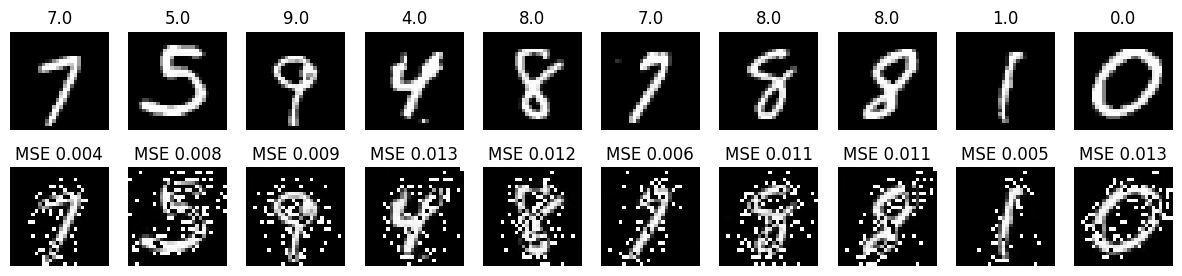

In [15]:
fix_random()
show_examples(model)

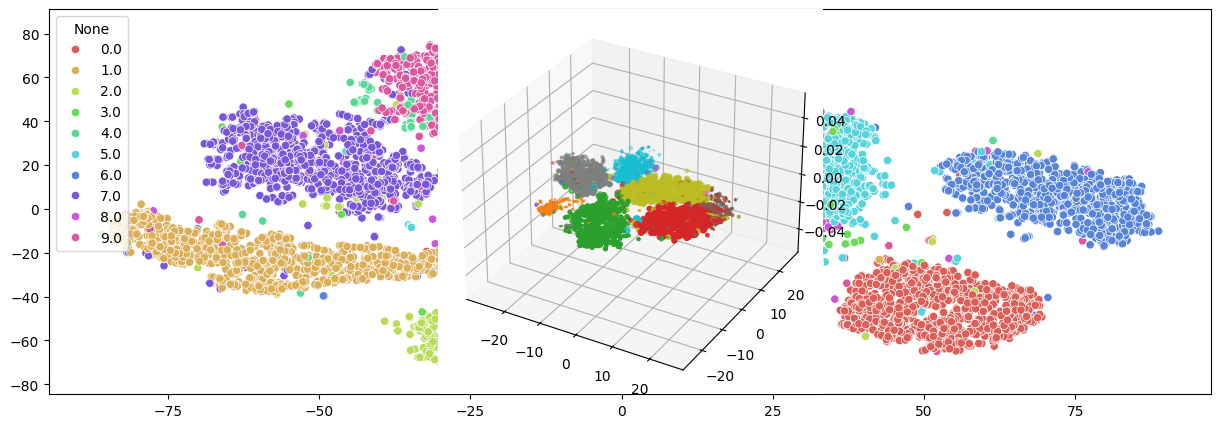

In [16]:
fix_random()
show_embeddings(model)

In [ ]:
fix_random()
show_embeddings(model, n_dimensions = 3)

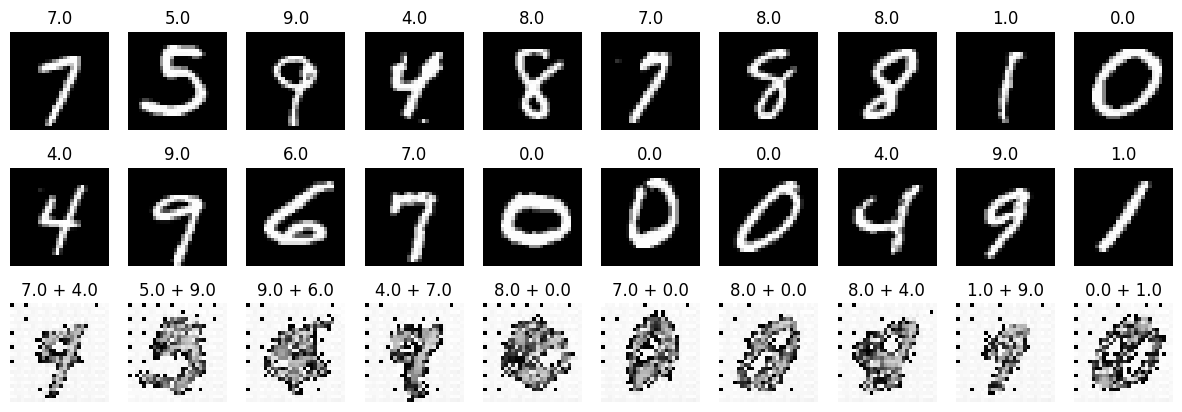

In [17]:
fix_random()
test_arithmetics(model)

# Conclusion